In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
np.random.seed(100)

# Tree

In [2]:
class RegressionTree:
  def __init__(self, max_depth=8):
    self.nodes = {}
    self.thresholds = {}
    self.leaves = {}
    self.max_depth = max_depth

  def criterion(self, true, pred):
    return np.linalg.norm(true-pred)

  def fit(self, X, y):
    self.grow_tree(X, y)
    print(f'Trained!')

  def grow_tree(self, X, y, depth=0, node_id='root'):
    X_l, y_l, X_r, y_r, depth, stop = self.split(X, y, depth, node_id)
    if not stop:
      for idx, data in enumerate([[X_l, y_l], [X_r, y_r]]):
        X_sub, y_sub = data
        child_id = f"{node_id}_{idx}"
        self.grow_tree(X_sub, y_sub, depth, child_id)

  def split(self, X, y, depth, node_id):
    split_flag, best_feature_idx, best_threshold, best_criterion, stop = False, None, None, np.inf, False

    pred_no_split = [float(y.mean())]*len(y)
    no_split = self.criterion(y, pred_no_split)

    for feature_idx, feature in enumerate(X.T):
        thresholds = np.percentile(feature, np.arange(0, 101, 1))

        for threshold in thresholds:
          true_l, true_r = y[(feature<threshold)], y[~(feature<threshold)]
          pred_l, pred_r = np.mean(y[(feature<threshold)]), np.mean(y[~(feature<threshold)])
          split_l, split_r = self.criterion(true_l, pred_l), self.criterion(true_r, pred_r)

          split = split_l + split_r

          if no_split>split: #if error is lower when splitting
            split_flag = True
            if best_criterion > split: #if this split is better than all the previous
              best_feature_idx = feature_idx
              best_threshold = threshold
              best_criterion = split

    if split_flag == True and depth < self.max_depth:
      depth += 1
      self.nodes[node_id] = best_feature_idx
      self.thresholds[node_id] = float(best_threshold)

      y_l, y_r = y[~(X.T[best_feature_idx]<best_threshold)], y[(X.T[best_feature_idx]<best_threshold)]
      X_l, X_r = X[~(X.T[best_feature_idx]<best_threshold)], X[(X.T[best_feature_idx]<best_threshold)]
    else:
      self.leaves[node_id] = float(y.mean())
      stop = True
      y_l, y_r, X_l, X_r = None, None, None, None

    return X_l, y_l, X_r, y_r, depth, stop

  def predict(self, X):
    preds = []
    for obj in X:
      node = 'root'
      while True:
        if node in self.leaves:
          pred = self.leaves[node]
          preds.append(pred)
          break

        feature = self.nodes[node]
        thr = self.thresholds[node]
        if obj[feature] > thr:
          node += '_0'
        else:
          node += '_1'
    return np.array(preds)

# Simple test

In [3]:
rng = np.random.RandomState(10)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

In [4]:
tree = RegressionTree(max_depth=4)
tree.fit(X,y)

tree2 = RegressionTree(max_depth=8)
tree2.fit(X,y)

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Trained!
Trained!


In [5]:
rng = np.random.RandomState(2)
X_test = np.sort(5 * rng.rand(80, 1), axis=0)
y_test = np.sin(X_test).ravel()
y_test[::5] += 3 * (0.5 - rng.rand(16))

y_1 = tree.predict(X_test)
y_2 = tree2.predict(X_test)

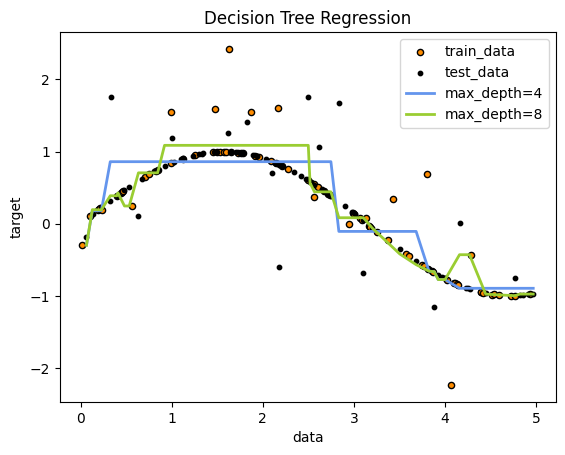

In [9]:
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="train_data")
plt.scatter(X_test, y_test, s=10, edgecolor="black", c="black", label="test_data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=4", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=8", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

# Test 2

In [36]:
n = 10000
x1 = np.random.uniform(0.01, 1, n)
x2 = np.random.uniform(0.01, 1, n)
X = np.column_stack([x1,x2])
y = np.where(
    (x1 < 0.8) & (x2 > 0.9),
    np.sin(1 / (x1 * x2 + 1e-3)),
    3 * np.exp(-(x1 - 0.5)**2 - (x2 - 0.5)**2)
)

In [37]:
n = 1000
x1_test = np.random.uniform(0.01, 1, n)
x2_test = np.random.uniform(0.01, 1, n)
X_test = np.column_stack([x1_test,x2_test])
y_test = np.where(
    (x1_test < 0.8) & (x2_test > 0.9),
    np.sin(1 / (x1_test * x2_test + 1e-3)),
    3 * np.exp(-(x1_test - 0.5)**2 - (x2_test - 0.5)**2)
)
preds = tree.predict(X_test)

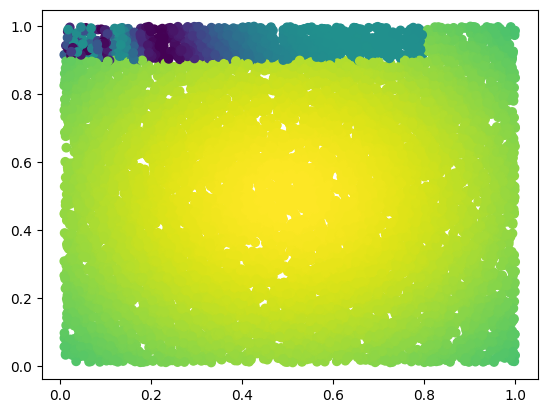

In [38]:
plt.scatter(x1,x2, c=y)

In [39]:
tree = RegressionTree(max_depth=3)
tree.fit(X,y)

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Trained!


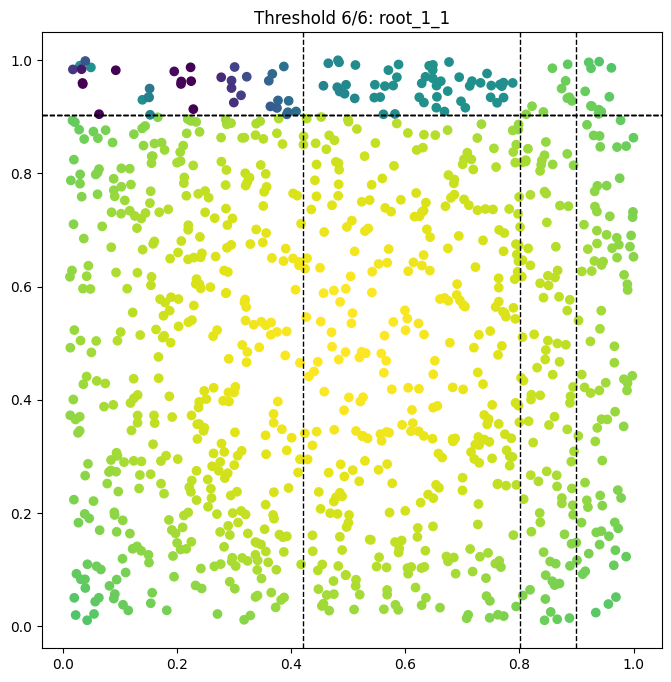

In [40]:
def animate(i):
    plt.clf()
    plt.scatter(x1_test, x2_test, c=y_test)

    for j, node_inner in enumerate(list(tree.nodes.keys())[:i+1]):
        feature = tree.nodes[node_inner]
        thr = tree.thresholds[node_inner]
        if feature == 0:
            plt.axvline(thr, ls='--', lw=1, color='black')
        else:
            plt.axhline(thr, ls='--', lw=1, color='black')

    plt.title(f'Threshold {i+1}/{len(tree.nodes)}: {list(tree.nodes.keys())[i]}')


fig = plt.figure(figsize=(8, 8))
anim = animation.FuncAnimation(fig, animate, frames=len(tree.nodes), interval=1000, repeat=True)

writer = PillowWriter(fps=1)
anim.save('tree_animation.gif', writer=writer)
plt.show()